# Głęboka sieć neuronowa w aspektowej analizie wydźwięku

## Tomek Korbak

#### 24 maja 2016


# Problem

Wytrenować klasyfikator, który dostając na wejściu zdanie języka polskiego, zwróci jego wydźwięk, to znaczy słowo wyrażające opinię.

In [31]:
import json
from itertools import chain
from pprint import pprint
from time import time
import os

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from gensim.models import Word2Vec
from gensim.corpora.dictionary import Dictionary


os.environ['THEANO_FLAGS'] = "device=gpu1"    
import theano
# theano.config.device = 'gpu' # Compute using GPU
# theano.config.floatX = 'float32'

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.utils.visualize_util import plot

np.random.seed(1337)

print theano.config.device

/home/tomek/.virtualenvs/deeplearning/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


gpu0


In [2]:
def indices_to_one_hot_encodings(index, vector_length):
    return [[1, 0] if i == index else [0, 1] for i in xrange(vector_length)]

In [3]:
# Load and process treebank data

treebank_file1 = open('json/OPTA-treebank-0.1.json')
treebank_file2 = open('skladnica_output.json')
treebank = chain(list(json.load(treebank_file1)), list(json.load(treebank_file2)))

X = []
y = []
labels = []
for entry in treebank:
    tree = entry['parsedSent']
    words = []
    sentiment = None
    for index, node in enumerate(tree):
        word = node.split('\t')[1].lower()
        words.append(word)
        if node.split('\t')[10] == 'S':
            sentiment = index
    if sentiment:
        labels.append(words[sentiment])
        X.append(words)
        y.append(indices_to_one_hot_encodings(sentiment, len(words)))

dataset_length = len(X)
slicing_point = int(dataset_length*0.9)

X_train_raw = X[:slicing_point]
y_train_raw = y[:slicing_point]
X_test_raw = X[slicing_point+1:]
y_test_raw = y[slicing_point+1:]

treebank_vocabulary = set(chain(*X))
print len(treebank_vocabulary)

X_train = X_train_raw 
y_train = labels

len(X_train) + len(X_test_raw)

3906


1431

In [4]:
# Przykłady z danych treningowych:

for index in [2, 44, 111, 384, 69]:
    print ' '.join(X_train[index]), '\n', y_train[index], '\n'

raczej nie dla młodych chłopców . 
młodych 

spokojnie mogą konkurować z nowymi zapachami . 
konkurować 

mają one wyjątkowy zapach , który długo utrzymuje się na skórze . 
wyjątkowy 

idealnie pasuje na każdą sylwetkę . 
pasuje 

: ) i macie rację-to dostojny zapach , nie dla chłystków w dresach . 
dostojny 



Dane pochodzą z ręcznie tagowanego treebanku (korpusu anotowanego składniowo) opracowanego przez Zespół Inżynierii Lingwistycznej IPI PAN na bazie Narodowego Korpusu Języka Polskiego (Wawer, 2015).

Treebank liczy około 1431 zdania. (To dość mało).

In [5]:
w2v_model = Word2Vec.load('w2v_allwiki_nkjp300_200.model')

In [6]:
# Import w2v's dictionary to a bag-of-words model
w2v_vocabulary = Dictionary()
w2v_vocabulary.doc2bow(w2v_model.vocab.keys(), allow_update=True)
print w2v_vocabulary.items()[:10]

[(0, u'zapachnie'), (1, u'PORADNI'), (2, u'Fitelberga'), (3, u'komedianta'), (4, u'Zaprzesta\u0107'), (5, u'Nampo'), (6, u'Schloendorff'), (7, u'zn\u0119kanym'), (8, u'synkopy'), (9, u'unifikacji')]


In [7]:
# Initialize dicts for representing w2v's dictionary as indices and 200-dim vectors
w2indx = {v: k+1 for k, v in w2v_vocabulary.items()}
w2vec = {word: w2v_model[word] for word in w2indx.keys()}

In [8]:
w2v_vocabulary_size = len(w2indx) + 1
w2v_vocabulary_dimension = len(w2vec.values()[0])

In [9]:
def map_treebank_words_to_w2v_indices(treebank_data, w2indx):
    treebank_data_vec = []
    for sentence in treebank_data:
        vectorized_sentence = []
        for word in sentence:
            try:
                vectorized_sentence.append(w2indx[word])
            except KeyError:  # words absent in w2v model will be indexed as 0s
                vectorized_sentence.append(0)
        treebank_data_vec.append(vectorized_sentence)
    return treebank_data_vec 

X_train = map_treebank_words_to_w2v_indices(X_train_raw, w2indx)
X_test = map_treebank_words_to_w2v_indices(X_test_raw, w2indx)

print X_test[4]

[51615, 277138, 416148, 422622, 318134, 584324, 176240, 503788, 0]


In [10]:
# Define numpy weights matrix for embedding layer
embedding_weights = np.zeros((w2v_vocabulary_size , w2v_vocabulary_dimension))
for word, index in w2indx.items():
    embedding_weights[index, :] = w2vec[word]

In [11]:
# max sentence length
max(
    len(max(X_train, key=lambda sentence: len(sentence))),
    len(max(X_test, key=lambda sentence: len(sentence)))
)

39

In [12]:
# Normalize sequences length to 40 (will be extended with 0s)
sentence_length = 40
X_train = sequence.pad_sequences(X_train, maxlen=sentence_length)
X_test = sequence.pad_sequences(X_test, maxlen=sentence_length)

y_train = sequence.pad_sequences(y_train_raw, maxlen=sentence_length, value=[0, 1])
y_test = sequence.pad_sequences(y_test_raw, maxlen=sentence_length, value=[0, 1])

# print X_train[2]
# print y_train[2]

In [13]:
inputs = Input(shape=(sentence_length,), dtype='int32')

x = Embedding(
    input_dim=w2v_vocabulary_size, 
    output_dim=w2v_vocabulary_dimension,
    input_length=sentence_length,
    mask_zero=True,
    weights=[embedding_weights]
)(inputs)

lstm_out = LSTM(200, return_sequences=True)(x)

regularized_data = Dropout(0.3)(lstm_out)

predictions = TimeDistributed(Dense(2, activation='sigmoid'))(regularized_data)

model = Model(input=inputs, output=predictions)


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Architektura sieci

Zasadniczą rolę odegrają dwie warstwy, same będące pełnoprawnymi sieciami neuronowymi:
* Warstwa embedding, mapująca słowa na wektory liczb zmiennoprzecinkowych w sposób spełniający pewne kryteria
* Warstwa LSTM, sieć rekurencyjna szczególnie dobrze radzącą sobie z przetwarzaniem szeregów czasowych

In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 40)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)            (None, 40, 200)     141387200   input_1[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                      (None, 40, 200)     320800      embedding_1[0][0]                
____________________________________________________________________________________________________
dropout_1 (Dropout)                (None, 40, 200)     0           lstm_1[0][0]                     
___________________________________________________________________________________________

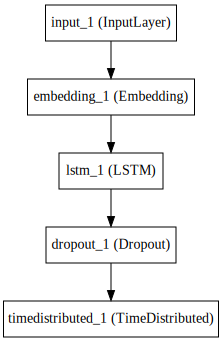

In [15]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Word embeddings

Word embedding to rodzaj statystycznego modelu językowego, który reprezentuje słowa (rzadziej złożone frazy lub całe dokumenty) jako punkty w *n*-wymiarowej przestrzeni liniowej.

Bardzo pożądaną cechą tego mapowania jest to, że relacje geometryczne między punktami tej przestrzeni *odwzorowują* relacje semantyczne między kodowanymi słowami.

Model taki trenuje się na bardzo dużych korpusach, każąc mu rozpoznawać wzorce współwystępowania słów. Najczęściej używanym algorytmem jest Word2Vec, opracowany przez Google (Mikolov et al., 2013a)

Skorzystaliśmy z gotowego embeddingu opracowanego przez IPI PAN, wytrenowanego (z użyciem Word2Vec) na całej polskojęzycznej Wikipedii oraz trzystumilionowym zbalansowanym podkorpusie NKJP.

In [16]:
# w modelu, który wykorzystaliśmy, słowa są reprezentowane jako
# 200-elementowe wektory 32-bitowych liczb zmiennoprzecinkowych
w2v_model['filozofia']

array([ 0.21601944,  0.44051808,  0.79559946, -1.68282688, -1.74369335,
       -1.28059053, -0.39722326,  2.53322577, -1.58840847,  2.89625692,
        0.21176136, -1.24656022, -1.851632  , -0.6131658 ,  0.09280811,
        0.2779803 ,  1.01950109, -3.0857935 ,  1.35601997,  1.5254544 ,
       -0.05327027, -0.82323092, -2.36823678, -0.4112888 , -1.64042878,
       -0.00641074,  0.90136075, -1.92337966, -3.58218908, -0.88566846,
        0.32599321, -2.20273089, -0.59569108, -1.85917747,  1.84256315,
        1.71745014, -0.37838364,  1.85855174,  1.9673841 , -0.79426467,
       -0.73808187,  0.3366071 , -2.58625793, -1.25763309,  0.27206179,
       -2.31144023, -0.47351044, -1.59982193, -2.06607461, -0.86752278,
        1.72592294, -0.69465017, -2.29019308,  1.78491342,  2.56894565,
       -0.80506438, -0.9288221 ,  1.59838867, -0.23708618, -1.67918718,
       -0.03720945, -1.16133761,  1.24743545,  1.21191287, -2.56924391,
        1.95127881, -1.05310512, -1.2471137 , -0.15193334,  2.89

In [17]:
w2v_model['filozofia'].shape

(200,)

In [18]:
w2v_model.similarity(u'filozofia', u'inżynieria')

0.49721665657867431

In [19]:
w2v_model.similarity(u'filozofia', u'nauka')

0.7536983594530452

In [20]:
w2v_model.similarity(u'filozofia', u'literatura')

0.71805379109199341

In [21]:
# wskaż słowo niepasujące do pozostałych
w2v_model.doesnt_match(['Kant', 'Leibniz', 'Derrida', 'Wittgenstein'])

'Derrida'

In [22]:
# Kobieta + król - mężczyzna = królowa
# Medialny przykład z (Mikolov et al., 2013b)
w2v_model.most_similar(positive=[u'kobieta', u'król'], negative=[u'mężczyzna'])

[(u'kr\xf3lowa', 0.7674408555030823),
 (u'cesarzowa', 0.669882595539093),
 (u'ksi\u0119\u017cniczka', 0.667689323425293),
 (u'ksi\u0119\u017cna', 0.6258757710456848),
 (u'caryca', 0.6103663444519043),
 (u'dama', 0.6032381057739258),
 (u'imperatorowa', 0.6007956862449646),
 (u'dynastia', 0.6004920601844788),
 (u'hrabina', 0.573236882686615),
 (u'elekcja', 0.5710059404373169)]

In [23]:
# Paryż - Francja + Polska = Warszawa
w2v_model.most_similar(positive=[u'Paryż', u'Polska'], negative=[u'Francja'])

[(u'Kulturalna', 0.5529330968856812),
 (u'Warszawa', 0.539720356464386),
 ('Berlin', 0.52457195520401),
 (u'Almanach', 0.5210937261581421),
 (u'Ekspres', 0.5202639698982239),
 (u'Literacki', 0.5191857814788818),
 (u'Wroc\u0142aw', 0.5109399557113647),
 (u'Krak\xf3w', 0.5104151964187622),
 (u'Londyn', 0.5102135539054871),
 (u'Energoprojekt', 0.5069946050643921)]

In [24]:
# filozofia - logika = literatura
w2v_model.most_similar(positive=[u'filozofia',], negative=[u'logika'])

[(u'malarstwo', 0.3539747893810272),
 (u'literatur\u0119', 0.35328927636146545),
 (u'humanistyczne', 0.3381263017654419),
 (u'buddyzm', 0.3335428237915039),
 (u'sport', 0.3307268023490906),
 (u'nauki', 0.32819390296936035),
 (u'astronomi\u0105', 0.3244932293891907),
 (u'filozoficzne', 0.32311704754829407),
 (u'krajoznawstwo', 0.3222176730632782),
 (u'tw\xf3rczo\u015b\u0107', 0.3211820423603058)]

In [25]:
# filozofia - postmodernizm = wiedza
w2v_model.most_similar(positive=[u'filozofia',], negative=[u'postmodernizm'])

[(u'wiedza', 0.49253422021865845),
 (u'praca', 0.4822917580604553),
 (u'nauka', 0.4789964258670807),
 (u'praktyka', 0.4766387343406677),
 (u'koncepcja', 0.47612860798835754),
 (u'teoria', 0.4726237952709198),
 (u'pisanina', 0.46762341260910034),
 (u'wizja', 0.46703991293907166),
 (u'problematyka', 0.4616868495941162),
 (u'inicjatywa', 0.45774880051612854)]

### Różnica wektorów „Paryż” i „Francja” reprezentuje pojęcie STOLICA?
<img src="capitals.png">

<center>Rzut (przez analizę składowych głównych) 1000-wymiarowego word embeddingu dla języka angielskiego. Przedruk z (Mikolov et al., 2013).</center>

# Warstwa LSTM

Long Short-Term Memory to bardzo popularna architektura rekurencyjnych sieci neuronowych, często używana do etykietowania lub predykcji szeregów czasowych (Hochreiter i Schmidhuber, 1997).

LSTM, dzięki połączeniom rekurencyjnym, utrzymuje coś w rodzaju *pamięci roboczej*, którą w każdej iteracji może aktualizować.

Zdolność do zapamiętywania odległych zależności (*long-term dependecies*), takich jak związek zgody, czyni ją najpopularniejszą architekturą do przetwarzania języka naturalnego.

## Przetwarzanie danych sekwencyjnych przez rekurencyjną sieć neuronową

Przy *n*-tej iteracji sieć dostaje na wejście *n*-ty element ciągu uczącego oraz pewien wektor zapamiętany z (*n-1*)-tej iteracji.

<img src="RNN-unrolled.png"> <br />

<center><small>Przedruk z http://colah.github.io/posts/2015-08-Understanding-LSTMs/</small></center>

Przy każdej iteracji sieć decyduje, która informacje usunąć z pamięci roboczej, a które od niej dodać. Reguły aktualizacji pamięci roboczej (jako macierz wag połączeń) także podlegają uczeniu.

<img src="LSTM3-chain.png"> <br />

<center><small>Przedruk z http://colah.github.io/posts/2015-08-Understanding-LSTMs/</small></center>

# Przepływ danych przez sieć

<img align="right" src="model.png">

Przykład | Opis
--- | ---
```'Kotek'``` | token
 89762 | indeks tokenu w modelu w2v
```array([ 0.21601944, ..., dtype=float32)``` | 200-elementowy wektor
 ...kolejne wektory... | dalsze etapy przetwarzania
 ```[0.9111, 0.0999]``` | zero-jedynkowy rozkład prawdopodobieństwa przynależności do klasy wydźwięk lub nie-wydźwięk

In [26]:
batch_size = 5
n_epoch = 5


hist = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=n_epoch, 
                 validation_data=(X_test, y_test), verbose=2)

# epochs = 10

# for i in range(epochs):
#     print('Epoch', i, '/', epochs)
#     model.fit

Train on 1288 samples, validate on 143 samples
Epoch 1/5
310s - loss: 0.2090 - acc: 0.9761 - val_loss: 0.2701 - val_acc: 0.9680
Epoch 2/5
329s - loss: 0.0860 - acc: 0.9872 - val_loss: 0.2604 - val_acc: 0.9699
Epoch 3/5
344s - loss: 0.0412 - acc: 0.9905 - val_loss: 0.2790 - val_acc: 0.9678
Epoch 4/5
358s - loss: 0.0233 - acc: 0.9917 - val_loss: 0.2874 - val_acc: 0.9657
Epoch 5/5
378s - loss: 0.0171 - acc: 0.9921 - val_loss: 0.3155 - val_acc: 0.9652


# Uczenie

<img src="plot.png">

In [5]:
# plt.rcParams['figure.figsize'] = (10,10)

# axes = plt.gca()
# x_min = hist.epoch[0]
# x_max = hist.epoch[-1]+1
# axes.set_xlim([x_min,x_max])

# plt.scatter(hist.epoch, hist.history['acc'], color='r')
# plt.plot(hist.history['acc'], color='r', label=u'Trafność mierzona na zbiorze treningowym')
# plt.scatter(hist.epoch, hist.history['val_acc'], color='c')
# plt.plot(hist.history['val_acc'], color='c', label=u'Trafność mierzona na zbiorze walidacyjnym')
# plt.xlabel('epoki')
# plt.ylabel(u'Trafność')
# plt.title(u'Trafność w kolejnych epokach')
# plt.legend()
# plt.show()

# Ocena trafności

Oceny trafności dokonano na 143-zdaniowym podzbiorze treebanku, niewykorzystanym podczas treningu.


In [64]:
# Ułamek poprawnie sklasyfikowanych tokenów
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print 'Test accuracy:', acc

Test accuracy: 0.965209802548


In [27]:
predictions = model.predict(X_test, verbose=1)

143/143 [==============================] - 0s     


In [54]:
def change_encoding_word(word):
    return 1 if list(np.rint(word)) == [1, 0] else 0

def change_encoding(one_hot_encoded_sentence):
    # Switch from ndarray([[0.88, 0.11], [0.34, 0.98]]) encoding to [1, 0] encoding 
    # and finally index number
    normalized_sentence = []
    for word in one_hot_encoded_sentence:
        normalized_sentence.append(change_encoding_word(word))
    return normalized_sentence

def accurately_evaluated_samples():
    total_accuracy = 0
    for n, sentence in enumerate(predictions):
        index_of_sentiment = np.argmax(change_encoding(sentence))
#         print change_encoding_word(y_test[n][index_of_sentiment])
        total_accuracy += change_encoding_word(y_test[n][index_of_sentiment])
    return total_accuracy
    
      


Wartość bardzo przeszacowana ze względu na nierównomierną częśtość występowania klas (1:39 dla wydźwięku vs nie-wydźwięku)

## Bardziej adekwatna metryka

In [65]:
# Ułamek tokenów-wydźwięków, które poprawnie rozpoznano jako wydźwięki
float(accurately_evaluated_samples())/y_test.shape[0]

0.34965034965034963

Nie wygląda imponująco, ale...
* Przy zgadywaniu trafność wynosiłaby 0,0625% (= $1/40^2$),
* Maksymalny możliwy wynik oscyluje wokół 80%, bo taka jest średnia zgodność ludzkich anotacji (Ogneva, 2012).

# Plany na przyszłość

* Zwiększenie trafności przewidywań
    * Dodanie drugiej (i kolejnych) warstwy LSTM powinno umożliwić budowanie przez sieć bardziej złożonych hierarchicznych reprezentacji zależności w zdaniach
    * Wydłużenie treningu sieci przy wykonywaniu obliczeń przez GPU lub szybszą maszynę
    
* Rozszerzenie problemu o inne trenowanie innych klasyfikatorów:
    * Ekstrakcja obiektów, których aspektom przypisywany jest wydźwięk
    * Klasyfikowanie wydźwięku (pozytywny lub negatywny) dla pary `<obiekt, wydźwięk>`

# Kod źródłowy

Repozytorium jest dostępne pod adresem: https://github.com/tomekkorbak/lstm-for-aspect-based-sentiment-analysis

# Użyte oprogramowanie

* Keras (wysokopoziomowy wrapper na Theano)
* Theano (implementacja sieci i jej treningu)
* Scikit-learn (walidacja)
* Gensim (model językowy Word2Vec)
* Numpy (pomocnicze obliczenia numeryczne)

# Bibliografia
1. Hochreiter, S. i Schmidhuber, J, (1997). Long Short-Term Memory, „Neural Computation”, 9 (8), ss. 1735-1780.
2. Mikolov, T.,  Sutskever, I.,  Chen, K., Corrado, G., i Dean, J. (2013a). Distributed Representations of Words and Phrases and their Compositionality. „Advances in Neural Information Processing Systems 26”, ss. 3111-3119.
3. Mikolov, T., Chen, K., Corrado, G. i Dean, J. (2013b). Efficient estimation of word representations in vector space. 
4. Ogneva, M. (2012). How Companies Can Use Sentiment Analysis to Improve Their Business
5. Wawer, A. (2015). Towards Domain-Independent Opinion Target Extraction. „IEEE 15th International Conference on Data Mining Workshops”, ss. 1326-1331.


# <center>Dziękuję za uwagę</center>

In [29]:
hist.history

{'acc': [0.97610637001832079,
  0.98715061578691377,
  0.99050852938653522,
  0.9916537196277091,
  0.99210014624625265],
 'loss': [0.20902245508807693,
  0.08603155619380938,
  0.041203499367635593,
  0.023266617574053673,
  0.017146764686461306],
 'val_acc': [0.96800700267711715,
  0.96993008193436203,
  0.96783217975309677,
  0.96573427965591008,
  0.96520980254753486],
 'val_loss': [0.2701167392355579,
  0.26044547015970404,
  0.2789940552694814,
  0.28738793543168717,
  0.31553373897409104]}

In [30]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

143/143 [==============================] - 0s     
('Test score:', 0.31553373897409104)
('Test accuracy:', 0.96520980254753486)
